In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge



# Load dataset
file_path = "ENB2012_data.csv"
data = pd.read_csv(file_path)

print("Dataset Head:\n", data.head())
print("\nDataset Info:")
print(data.info())



Dataset Head:
      X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      768 non-null    float64
 1   X2      768 non-null    float64
 2   X3      768 non-null    float64
 3   X4      768 non-null    float64
 4   X5      768 non-null    float64
 5   X6      768 non-null    int64  
 6   X7      768 non-null    float64
 7   X8      768 non-null    int64  
 8   Y1      768 non-null    float64
 9   Y2      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 K

In [130]:
num_features = ['X1','X2','X3','X4','X5','X7','X8']
X = data[['X1','X2','X3','X4','X6','X5','X7','X8']]
y = data['Y1']



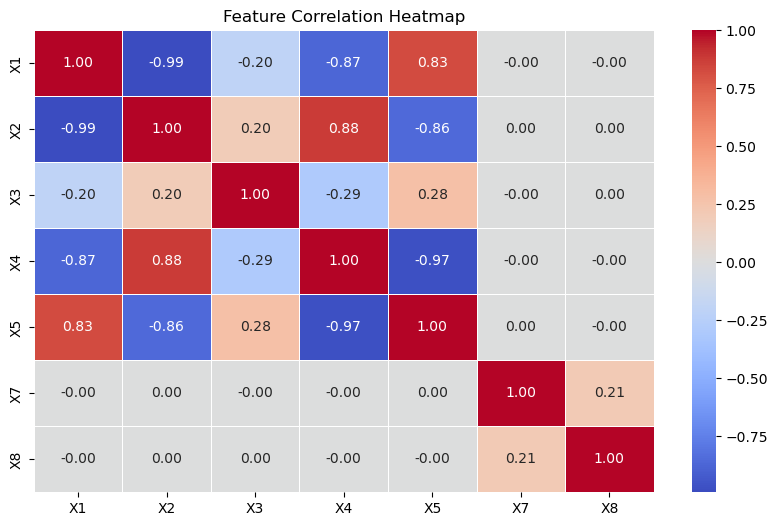

In [131]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[num_features].corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


weights = np.random.randn(X_train.shape[1])
bias = 0

learning_rate = 0.01
num_iterations = 1000

loss_values = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_list_scratch = []
r2_list_scratch = []

for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Gradient Descent for Linear Regression
    m = len(y_train_fold)
    for i in range(num_iterations):
        y_pred_train = np.dot(X_train_fold, weights) + bias
        cost = (1/(2*m)) * np.sum((y_pred_train - y_train_fold) ** 2)
        dw = (1/m) * np.dot(X_train_fold.T, (y_pred_train - y_train_fold))
        db = (1/m) * np.sum(y_pred_train - y_train_fold)
        weights -= learning_rate * dw
        bias -= learning_rate * db
        if i % 100 == 0:  # Store loss every 100 iterations
            loss_values.append(cost)

    y_pred_val_scratch = np.dot(X_val_fold, weights) + bias
    mse_list_scratch.append(mean_squared_error(y_val_fold, y_pred_val_scratch))
    r2_list_scratch.append(r2_score(y_val_fold, y_pred_val_scratch))

print(f" MSE (Scratch): {np.mean(mse_list_scratch):.2f}, R^2: {np.mean(r2_list_scratch):.2f}")

 MSE (Scratch): 8.97, R^2: 0.91


In [133]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Initial Evaluation of Model 1
print("\nRandom Forest - Initial Evaluation on Test Set:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf):.2f}")


Random Forest - Initial Evaluation on Test Set:
MSE: 0.25
R²: 1.00


In [134]:
ri_model = Ridge(alpha=1.0)
ri_model.fit(X_train, y_train)
y_pred_ri = ri_model.predict(X_test)

print("\nRidge - Initial Evaluation on Test Set:")
print(f"MSE: {mean_squared_error(y_test, y_pred_ri):.2f}")
print(f"R²: {r2_score(y_test, y_pred_ri):.2f}")


Ridge - Initial Evaluation on Test Set:
MSE: 9.21
R²: 0.91


In [135]:
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

In [136]:
print("\nBest Hyperparameters for Random Forest:", grid_search_rf.best_params_)



Best Hyperparameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}


In [137]:
param_grid_ri = {'alpha': [0.1, 1.0, 10.0]}
grid_search_ri = GridSearchCV(Ridge(), param_grid_ri, cv=5, scoring='neg_mean_squared_error')
grid_search_ri.fit(X_train, y_train)
best_ri = grid_search_ri.best_estimator_

In [138]:
print("\nBest Hyperparameters for Ridge:", grid_search_ri.best_params_)



Best Hyperparameters for Ridge: {'alpha': 0.1}


In [139]:
y_pred_rf_best = best_rf.predict(X_test)
print("\nRandom Forest - Evaluation after Hyperparameter Tuning on Test Set:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf_best):.2f}")
print(f"R²: {r2_score(y_test, y_pred_rf_best):.2f}")


Random Forest - Evaluation after Hyperparameter Tuning on Test Set:
MSE: 0.25
R²: 1.00


In [140]:
y_pred_ri_best = best_ri.predict(X_test)
print("\nRidge - Evaluation after Hyperparameter Tuning on Test Set:")
print(f"MSE: {mean_squared_error(y_test, y_pred_ri_best):.2f}")
print(f"R²: {r2_score(y_test, y_pred_ri_best):.2f}")


Ridge - Evaluation after Hyperparameter Tuning on Test Set:
MSE: 9.16
R²: 0.91


In [141]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd

# Ensure X_train is a DataFrame
if isinstance(X_train, np.ndarray):
    feature_names = [f"Feature_{i}" for i in range(X_train.shape[1])]  # Generic feature names
else:
    feature_names = X_train.columns  # Use actual column names if X_train is a DataFrame

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
feature_importance_rf = rf_model.feature_importances_

# Create DataFrame for better visualization
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,  # Use corrected feature names
    'Importance': feature_importance_rf
}).sort_values(by='Importance', ascending=False)

# Select top features (e.g., top 5 based on importance)
top_features_rf = feature_importance_df_rf.head(5)['Feature'].tolist()

print("\nBest Subset of Features for Random Forest:")
print(top_features_rf)



Best Subset of Features for Random Forest:
['Feature_0', 'Feature_1', 'Feature_3', 'Feature_5', 'Feature_6']


In [142]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Define hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]  # Added another hyperparameter for better tuning
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42), 
    param_grid_rf, 
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all CPU cores
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_

# Predictions using best model
y_pred_rf_best = best_rf.predict(X_test)

# Evaluation
print("\nRandom Forest - Best Hyperparameters:")
print(grid_search_rf.best_params_)




Random Forest - Best Hyperparameters:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


In [143]:
from sklearn.linear_model import Ridge
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter distribution for Ridge Regression
param_dist_ridge = {
    "alpha": uniform(0.1, 10)  # Continuous values for alpha
}

# Perform RandomizedSearchCV with 5-fold cross-validation
random_search_ridge = RandomizedSearchCV(
    Ridge(), 
    param_distributions=param_dist_ridge, 
    n_iter=20,  # Number of random combinations to test
    cv=5, 
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)

# Fit RandomizedSearchCV
random_search_ridge.fit(X_train, y_train)

# Best model
best_ridge = random_search_ridge.best_estimator_

# Predictions using best model
y_pred_ridge_best = best_ridge.predict(X_test)



In [144]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE

# Train Ridge model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Use RFE to select the best subset of features
selector = RFE(ridge_model, n_features_to_select=5)  # Select top 5 features
selector.fit(X_train, y_train)

# Get the best features using original column names
top_features_ridge = [num_features[i] for i in range(len(num_features)) if selector.support_[i]]

print("\nBest Subset of Features for Ridge Regression:")
print(top_features_ridge)



Best Subset of Features for Ridge Regression:
['X1', 'X2', 'X4', 'X7', 'X8']


In [145]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Select the best subset of features
best_features = ['Feature_0', 'Feature_1', 'Feature_3', 'Feature_5', 'Feature_2']
X_train_selected = X_train[:, [0, 1, 3, 5, 2]]  # Select columns by index
X_test_selected = X_test[:, [0, 1, 3, 5, 2]]  # Ensure the test set uses the same features

# Rebuild the Random Forest model with the best hyperparameters
final_rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=2,
    random_state=42
)

final_rf_model.fit(X_train_selected, y_train)

y_pred_final = final_rf_model.predict(X_test_selected)

mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n Final Random Forest Model Evaluation:")
print(f" MSE: {mse_final:.2f}")
print(f" R² Score: {r2_final:.2f}")



 Final Random Forest Model Evaluation:
 MSE: 9.34
 R² Score: 0.91



Performance Comparison:

Regression from ridge  - MSE: 9.16, R²: 0.91
Random Forest - MSE: 0.25, R²: 1.00

 Final Random Forest Model Evaluation:
 MSE: 9.34
 R² Score: 0.91


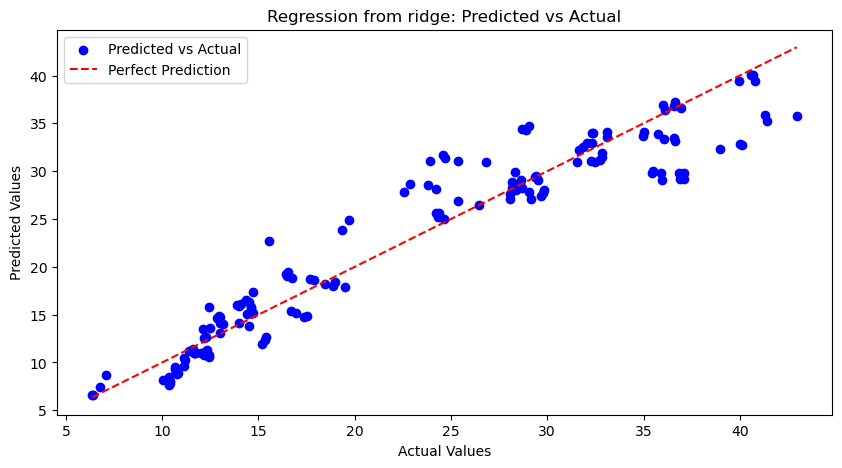

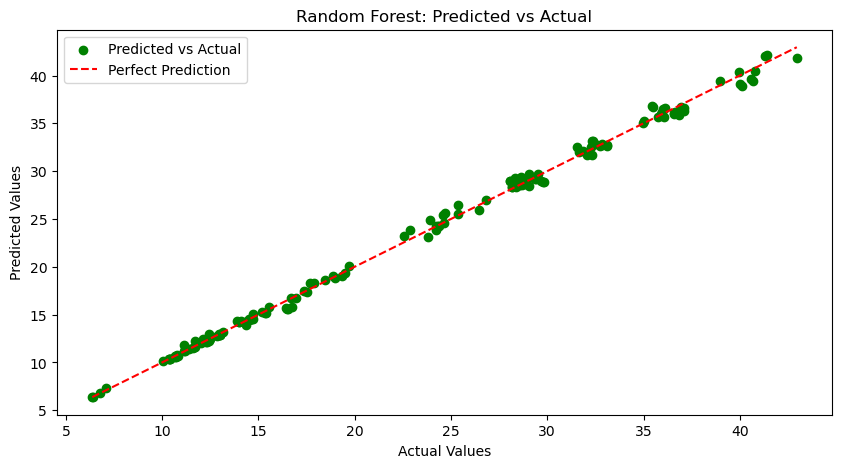

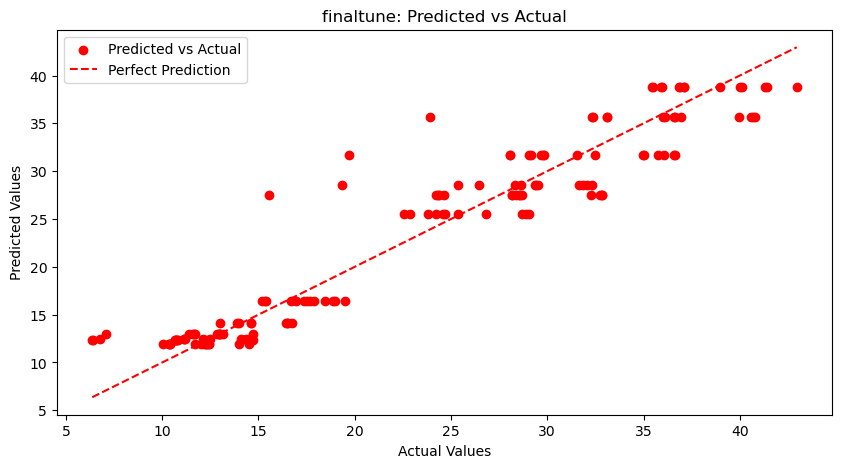

In [146]:
y_pred_ri_best = best_ri.predict(X_test)

y_pred_rf_best = best_rf.predict(X_test)

print("\nPerformance Comparison:")

mse_ri = mean_squared_error(y_test, y_pred_ri_best)
r2_ri = r2_score(y_test, y_pred_ri_best)

mse_rf = mean_squared_error(y_test, y_pred_rf_best)
r2_rf = r2_score(y_test, y_pred_rf_best)

print(f"\nRegression from ridge  - MSE: {mse_ri:.2f}, R²: {r2_ri:.2f}")
print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

print("\n Final Random Forest Model Evaluation:")
print(f" MSE: {mse_final:.2f}")
print(f" R² Score: {r2_final:.2f}")

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_ri, color='blue', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Regression from ridge: Predicted vs Actual')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rf, color='green', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest: Predicted vs Actual')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_final, color='red', label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('finaltune: Predicted vs Actual')
plt.legend()
plt.show()
